In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [2]:
from tqdm import tqdm

In [3]:
from env import make_env, make_vec_env
env = make_env(render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(-inf, inf, (17,), float64)
Action space:  Box(-1.0, 1.0, (6,), float32)


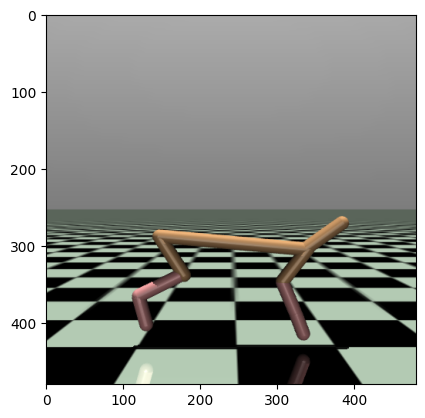

In [4]:
import matplotlib.pyplot as plt

env.reset()
plt.imshow(env.render())

In [5]:
!pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

zsh:1: command not found: pip


FileNotFoundError: [Errno 2] No such file or directory: 'nvidia-smi'

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from policy import PolicyModel, Policy
from ppo import make_ppo_sampler, PPO, EWMA_PPO
from adam import rescale_adam
from IPython.display import clear_output

# Создаём окружения
num_envs = 2
envs = {num_minibatches: make_vec_env(num_envs=num_envs) for num_minibatches in [8, 16, 32]}

# Определяем размеры состояний и действий
state_dim = envs[8].single_observation_space.shape[0]
action_dim = envs[8].single_action_space.shape[0]

# Создаём модели
models = {}
optimizers = {}
ppos = {}
schedulers = {}
num_default_minibatches = 32
num_minibatches_list = [8, 16, 32]  # Разные размеры мини-батчей

for num_minibatches in num_minibatches_list:
    for algo in [PPO, EWMA_PPO]:
        env_curr = make_vec_env(num_envs=num_envs)
        model = PolicyModel(state_dim, action_dim).cpu()
        policy = Policy(model)
        
        sampler = make_ppo_sampler(env_curr, policy, num_minibatches=num_minibatches)
        optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
        
        if algo is EWMA_PPO:
            C = num_default_minibatches / num_minibatches
            rescale_adam(optimizer=optimizer, C=C)
            
        ppo = algo(policy, optimizer)
        lr_mult = lambda epoch: (1 - (epoch / 150000))
        sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)
        
        models[(algo.__name__, num_minibatches)] = (policy, sampler, ppo, env_curr)
        optimizers[(algo.__name__, num_minibatches)] = optimizer
        schedulers[(algo.__name__, num_minibatches)] = sched

# Инициализируем массивы для хранения результатов
steps = []
rewards = {(algo.__name__, num_minibatches): [] for num_minibatches in num_minibatches_list for algo in [PPO, EWMA_PPO]}
n_update = 100  # Как часто обновлять график

# Основной цикл обучения
n_iter = 150000
for i in tqdm(range(n_iter)):
    for key in models:
        policy, sampler, ppo, env_curr = models[key]
        optimizer = optimizers[key]
        sched = schedulers[key]
        
        trajectory = sampler.get_next()
        ppo.step(trajectory)
        sched.step()
    
    if (i + 1) % n_update == 0:
        steps.append(i)
        for key in models:
            env_curr = models[key][-1]
            rewards[key].append(env_curr.env.env.env.return_queue[-1])
        
        clear_output(wait=True)  # Удаляет старый график перед обновлением
        plt.figure(figsize=(10, 18))
        
        plt.subplot(3, 1, 1)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("PPO", num_minibatches)], label=f"PPO minibatches={num_minibatches}")
            plt.plot(steps, rewards[("EWMA_PPO", num_minibatches)], '--', label=f"EWMA_PPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("PPO vs EWMA_PPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        # График 2: Только PPO с разными размерами мини-батчей
        plt.subplot(3, 1, 2)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("PPO", num_minibatches)], label=f"PPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("PPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        # График 3: Только EWMA_PPO с разными размерами мини-батчей
        plt.subplot(3, 1, 3)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("EWMA_PPO", num_minibatches)], label=f"EWMA_PPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("EWMA_PPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        plt.show()



NameError: name 'make_vec_env' is not defined